# Program Assignment #2 - 
# Decision Tree & Random Forest & KNN & PCA
---

## Name: 李勝維
## Student ID: 0711239
## Dataset: student-mat.csv (Mathematics)
---

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

# Load data
1. Read csv  
2. Shuffle data  
3. transform non-numerical values to one-hot encoding  
4. transform label to binary / 5 class type

In [290]:
from sklearn.preprocessing import OneHotEncoder
# load data
raw_data = pd.read_csv("data/student-mat.csv", sep=";").values

# shuffle data
np.random.shuffle(raw_data)

x, y = raw_data[..., :-1], raw_data[..., -1]
Categorical_Features = [0, 1, 3, 4, 5, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 22]
Numerical_Features = [2, 6, 7, 12, 13, 14, 23, 24, 25, 26, 27, 28, 29, 30, 31]

# transform x to one-hot
x_encoder = OneHotEncoder(sparse=False)
x_cat = x_encoder.fit_transform(x[..., Categorical_Features])
x_num = x[..., Numerical_Features]
x = np.hstack((x_cat, x_num))

# transform y to binary / 5 class type
y_binary = np.digitize(y, [10]) # if G3 < 10, y = 0
y_5class = np.digitize(y, [21, 16, 14, 12, 10])
del y

# Principal components analysis
Transforms training set and test set based on transformations learnt from training set

In [291]:
from sklearn.decomposition import PCA
def pca_transform(train, test, k=10):
    pca = PCA(n_components=k)
    train = pca.fit_transform(train)
    test = pca.transform(test)
    return train, test

# Model Construction
### Algorithm behind decision tree:  
DecisionTreeClassifier from sklearn.tree uses CART (Classification and Regression Trees) algorithm, which is similar to C4.5 algorithm, but it supports numerical value (regression) and constructs binary trees, using feature and its threshold which yields the largest information gain at each node.  
For classification tree, CART uses impurity function (IF) to split, and we use gini index in this instance.  
For regresstion tree, CART minimizes square error between each child set and its ground truth.  

### Random forest  
We randomly select 20% of our training set to build each tree (with all the features), with three different tree numbers [4, 8, 16]  

### Difference between K-fold cross-validation and Random Forest:  
* K-fold: 一種「驗證模型擬合性能」的方法，最主要的目的是「幫助我們選擇模型的設定（超參數等）」，因為我們不能將training set來作為測試基準，否則會無法測試出model的泛化程度，即training set的偏誤（bias）無法被糾正，或是無法發現model的over-fitting問題。  

* Random Forest: 一種「建立模型」的方法，其最主要的目的是「減少模型的可學習參數量（大小）」。即使每個tree都只會用到一部分的training set，但我們還是能夠（機率性的）使用到整個training set，而且每次的結果都是參考所有的訓練資料而來，會這麼做的理由是，如果使用整個training set來建單一個樹，很有可能會有樹過深等等的問題，而random forest可以有效的減少參數量，但是對於K-fold想要解決的問題並沒有幫助，因此這兩個方法結合使用才是最好的。  

### KNN
Three different values of K = [8, 16, 32]


In [292]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
DTclf = DecisionTreeClassifier(random_state=0)
RF_nums = [4, 8, 16]
RFclfs = {k:RandomForestClassifier(max_samples=0.2,random_state=0, n_estimators=k) for k in RF_nums}
KNN_nums = [8, 16, 32]
KNNclfs ={k:KNeighborsClassifier(n_neighbors=k) for k in KNN_nums}

# Validation
都是畫表格、算metrics的code

In [293]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from tabulate import tabulate

def show_multiclass_score(y_pred, y_test, y_label, silent=False):
    # shows metrics for each class
    table_data = list()
    table_header = []
    accuracy = accuracy_score(y_test, y_pred)
    recalls = recall_score(y_test, y_pred, average=None)
    precisions = precision_score(y_test, y_pred, average=None)
    table_header = ['Metrics', 'Accuracy', 'Recall', 'Precision']
    for name, recall, precision in zip(y_label, recalls, precisions):
        table_data.append([name,accuracy, recall, precision])
    if not silent:
        print(tabulate(table_data, table_header, tablefmt='fancy_grid'))

    return accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='macro')



def compare_PCA(clf, class_type='binary'):
    ret = []
    # with PCA
    table_data = list()
    if class_type == 'binary':
        y = y_binary
        table_header = ['Confusion matrix', 'G3 < 10', 'G3 >= 10']
    else:
        y = y_5class
        table_header = ['Confusion matrix', 'I', 'II', 'III', 'IV', 'V']
    KF = KFold(n_splits=3)
    cat_pred = np.array([])
    cat_gt = np.array([])
    for train_idx, test_idx in KF.split(x):
        x_train, x_test, y_train, y_test = x[train_idx], x[test_idx], y[train_idx], y[test_idx]
        x_train, x_test = pca_transform(x_train, x_test)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        cat_pred = np.concatenate([cat_pred, y_pred], axis=0)
        cat_gt = np.concatenate([cat_gt, y_test], axis=0)
    y_pred = cat_pred
    y_test = cat_gt
    c_m = confusion_matrix(y_test, y_pred)/3
    for idx, row in enumerate(c_m):
        table_data.append([table_header[idx+1], *row])
    print("1. With PCA:")
    print(tabulate(table_data, table_header, tablefmt='fancy_grid'))
    ret.append(show_multiclass_score(y_pred, y_test, table_header[1:]))

    # without PCA
    table_data = list()
    KF = KFold(n_splits=3)
    cat_pred = np.array([])
    cat_gt = np.array([])
    for train_idx, test_idx in KF.split(x):
        x_train, x_test, y_train, y_test = x[train_idx], x[test_idx], y[train_idx], y[test_idx]
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        cat_pred = np.concatenate([cat_pred, y_pred], axis=0)
        cat_gt = np.concatenate([cat_gt, y_test], axis=0)
    y_pred = cat_pred
    y_test = cat_gt
    c_m = confusion_matrix(y_test, y_pred)/3
    for idx, row in enumerate(c_m):
        table_data.append([table_header[idx+1], *row])
    print("2. Without PCA:")
    print(tabulate(table_data, table_header, tablefmt='fancy_grid'))
    ret.append(show_multiclass_score(y_pred, y_test, table_header[1:]))
    print()

    return ret

def compare_K(clf_dict, class_type='binary', silent=False):
    ret = list()
    for K, clf in clf_dict.items():
        table_data = list()
        if class_type == 'binary':
            y = y_binary
            table_header = ['Confusion matrix', 'G3 < 10', 'G3 >= 10']
        else:
            y = y_5class
            table_header = ['Confusion matrix', 'I', 'II', 'III', 'IV', 'V']
        KF = KFold(n_splits=3)
        cat_pred = np.array([])
        cat_gt = np.array([])
        for train_idx, test_idx in KF.split(x):
            x_train, x_test, y_train, y_test = x[train_idx], x[test_idx], y[train_idx], y[test_idx]
            clf.fit(x_train, y_train)
            y_pred = clf.predict(x_test)
            cat_pred = np.concatenate([cat_pred, y_pred], axis=0)
            cat_gt = np.concatenate([cat_gt, y_test], axis=0)
        y_pred = cat_pred
        y_test = cat_gt
        c_m = confusion_matrix(y_test, y_pred)/3
        for idx, row in enumerate(c_m):
            table_data.append([table_header[idx+1], *row])
        if not silent:
            print(f"For K = {K}:")
            print(tabulate(table_data, table_header, tablefmt='fancy_grid'))
        ret.append(show_multiclass_score(y_pred, y_test, table_header[1:], silent=silent))
        if not silent:
            print()
    return ret
    

# Results Part 1: compare with and without PCA

In [294]:
# compare with / without PCA on three kinds of model on binary classification
table_header = ['Model setting', 'Accuracy', 'Recall (average)', 'Precision (average)']
table_data = list()
print(f"\n{'#'*40} Binary Classification {'#'*40}\n")
# for DT
print("Result for DT comparing with and without PCA:")
rst = compare_PCA(DTclf, 'binary')
table_data.append(['DT with PCA', *rst[0]])
table_data.append(['DT without PCA', *rst[1]])
# for RF
print("Result for Random Forest comparing with and without PCA:")
rst = compare_PCA(RFclfs[RF_nums[len(RF_nums)//2]], 'binary')
table_data.append(['RF with PCA', *rst[0]])
table_data.append(['RF without PCA', *rst[1]])
# for KNN
print("Result for KNN comparing with and without PCA:")
rst = compare_PCA(KNNclfs[KNN_nums[len(KNN_nums)//2]], 'binary')
table_data.append(['KNN with PCA', *rst[0]])
table_data.append(['KNN without PCA', *rst[1]])
print()
print("Final results (Binary):")
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))

# compare with / without PCA on three kinds of model on 5 class classification
print(f"\n{'#'*40} 5-Level Classification {'#'*40}\n")
# for DT
table_data = list()
print("Result for DT comparing with and without PCA:")
rst = compare_PCA(DTclf, '5-class')
table_data.append(['DT with PCA', *rst[0]])
table_data.append(['DT without PCA', *rst[1]])
# for RF
print("Result for Random Forest comparing with and without PCA:")
rst = compare_PCA(RFclfs[RF_nums[len(RF_nums)//2]], '5-class')
table_data.append(['RF with PCA', *rst[0]])
table_data.append(['RF without PCA', *rst[1]])
# for KNN
print("Result for KNN comparing with and without PCA:")
rst = compare_PCA(KNNclfs[KNN_nums[len(KNN_nums)//2]], '5-class')
table_data.append(['KNN with PCA', *rst[0]])
table_data.append(['KNN without PCA', *rst[1]])
print()
print("Final results (5-Level):")
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))


######################################## Binary Classification ########################################

Result for DT comparing with and without PCA:
1. With PCA:
╒════════════════════╤═══════════╤════════════╕
│ Confusion matrix   │   G3 < 10 │   G3 >= 10 │
╞════════════════════╪═══════════╪════════════╡
│ G3 < 10            │   32.3333 │    11      │
├────────────────────┼───────────┼────────────┤
│ G3 >= 10           │   10      │    78.3333 │
╘════════════════════╧═══════════╧════════════╛
╒═══════════╤════════════╤══════════╤═════════════╕
│ Metrics   │   Accuracy │   Recall │   Precision │
╞═══════════╪════════════╪══════════╪═════════════╡
│ G3 < 10   │   0.840506 │ 0.746154 │    0.76378  │
├───────────┼────────────┼──────────┼─────────────┤
│ G3 >= 10  │   0.840506 │ 0.886792 │    0.876866 │
╘═══════════╧════════════╧══════════╧═════════════╛
2. Without PCA:
╒════════════════════╤═══════════╤════════════╕
│ Confusion matrix   │   G3 < 10 │   G3 >= 10 │
╞════════════════════╪═

# Results Part 2: compare different number of trees for random forest

In [295]:
table_header = ['Model setting', 'Accuracy', 'Recall (average)', 'Precision (average)']
table_data = list()
print(f"\n{'#'*40} Binary Classification {'#'*40}\n")
# for random forest
print("Result for Random Forest comparing diffent tree number:")
rst = compare_K(RFclfs, 'binary')
for K, data in zip(RFclfs.keys(), rst):
    table_data.append([f'RF with {K} trees', *data])
print()
print("Final results (Binary):")
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))

table_data = list()
print(f"\n{'#'*40} 5-Level Classification {'#'*40}\n")
# for random forest
print("Result for Random Forest comparing diffent tree number:")
rst = compare_K(RFclfs, 'binary')
for K, data in zip(RFclfs.keys(), rst):
    table_data.append([f'RF with {K} trees', *data])
print()
print("Final results (5-Level):")
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))


######################################## Binary Classification ########################################

Result for Random Forest comparing diffent tree number:
For K = 4:
╒════════════════════╤═══════════╤════════════╕
│ Confusion matrix   │   G3 < 10 │   G3 >= 10 │
╞════════════════════╪═══════════╪════════════╡
│ G3 < 10            │   36.6667 │    6.66667 │
├────────────────────┼───────────┼────────────┤
│ G3 >= 10           │   12      │   76.3333  │
╘════════════════════╧═══════════╧════════════╛
╒═══════════╤════════════╤══════════╤═════════════╕
│ Metrics   │   Accuracy │   Recall │   Precision │
╞═══════════╪════════════╪══════════╪═════════════╡
│ G3 < 10   │   0.858228 │ 0.846154 │    0.753425 │
├───────────┼────────────┼──────────┼─────────────┤
│ G3 >= 10  │   0.858228 │ 0.864151 │    0.919679 │
╘═══════════╧════════════╧══════════╧═════════════╛

For K = 8:
╒════════════════════╤═══════════╤════════════╕
│ Confusion matrix   │   G3 < 10 │   G3 >= 10 │
╞══════════════════

# Results Part 3: compare different K for KNN

In [296]:
table_header = ['Model setting', 'Accuracy', 'Recall (average)', 'Precision (average)']
table_data = list()
print(f"\n{'#'*40} Binary Classification {'#'*40}\n")
# for KNN
print("Result for KNN comparing diffent K:")
rst = compare_K(KNNclfs, 'binary')
for K, data in zip(KNNclfs.keys(), rst):
    table_data.append([f'KNN with K = {K}', *data])
print()
print("Final results (Binary):")
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))

table_data = list()
print(f"\n{'#'*40} 5-Level Classification {'#'*40}\n")
# for KNN
print("Result for KNN comparing diffent K:")
rst = compare_K(KNNclfs, 'binary')
for K, data in zip(KNNclfs.keys(), rst):
    table_data.append([f'KNN with K = {K}', *data])
print()
print("Final results (5-Level):")
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))


######################################## Binary Classification ########################################

Result for KNN comparing diffent K:
For K = 8:
╒════════════════════╤═══════════╤════════════╕
│ Confusion matrix   │   G3 < 10 │   G3 >= 10 │
╞════════════════════╪═══════════╪════════════╡
│ G3 < 10            │   35.3333 │     8      │
├────────────────────┼───────────┼────────────┤
│ G3 >= 10           │   10      │    78.3333 │
╘════════════════════╧═══════════╧════════════╛
╒═══════════╤════════════╤══════════╤═════════════╕
│ Metrics   │   Accuracy │   Recall │   Precision │
╞═══════════╪════════════╪══════════╪═════════════╡
│ G3 < 10   │   0.863291 │ 0.815385 │    0.779412 │
├───────────┼────────────┼──────────┼─────────────┤
│ G3 >= 10  │   0.863291 │ 0.886792 │    0.907336 │
╘═══════════╧════════════╧══════════╧═════════════╛

For K = 16:
╒════════════════════╤═══════════╤════════════╕
│ Confusion matrix   │   G3 < 10 │   G3 >= 10 │
╞════════════════════╪═══════════╪════

# Comparison & Conclution
(DT代表decision tree, RF代表random forest, KNN代表KNN)
## 有無 PCA 的比較  
可以看到，在5-level classification中，RF使用了經過PCA降維後的資料，其準確度會稍有提升，我想這是因為PCA將資料降維後，RF的可訓練參數（node）數量會大幅度的下降，因此避免了overfitting的困擾；而DT和KNN則是會稍有下降，或許是因為DT在經過PCA降維後，因為隨機，導致建出來的樹形狀比較奇怪，而KNN要視資料分佈的domain來決定，但是因為下降幅度都非常小，但是可以大幅的減少計算量並加速計算，因此使用PCA還是很有好處的。  
## RF 中不同 tree 數目的比較
在4、8、16三種設定下，使用8棵樹可以達到最好的效能，我認為這也同樣受到了訓練資料量，和可訓練參數量之間平衡的影響。  
## KNN 中不同 K 數目的比較
我認為這個單純是 KNN 對於不同的資料分佈會有不同的K合適，因此做實驗時，多次實驗來決定參數是很重要的！
## Feedbacks
可不可以減少一點畫表格的數量QQ，每次畫表格的時間比實際建模型訓練的時間還要久，而且感覺要做的實驗有點多，像是這次的作業，如果會做5-level classification，應該做binary classification就完全沒有問題吧，我覺得或許可以改成bonus的形式，就是可以選擇做其中一種，然後比較困難的可以小加分，這樣可以照顧到程度比較不好的同學，然後都寫的出來的負擔也不會這麼重

# Questions
## Decision Tree
### Show the prediction and reasoning of one arbitrary sample in the testing set.
binary classification  
sample from testing set = [8.60231553. 2.40520527, 2.30684342, -1.45726746, -1.72703874e-03] (after PCA)  
根據tree的走法（向右為>thershold）：  
![alt text](Reasong-DT.png "Reasoning:")  

Thus, prediction = 0

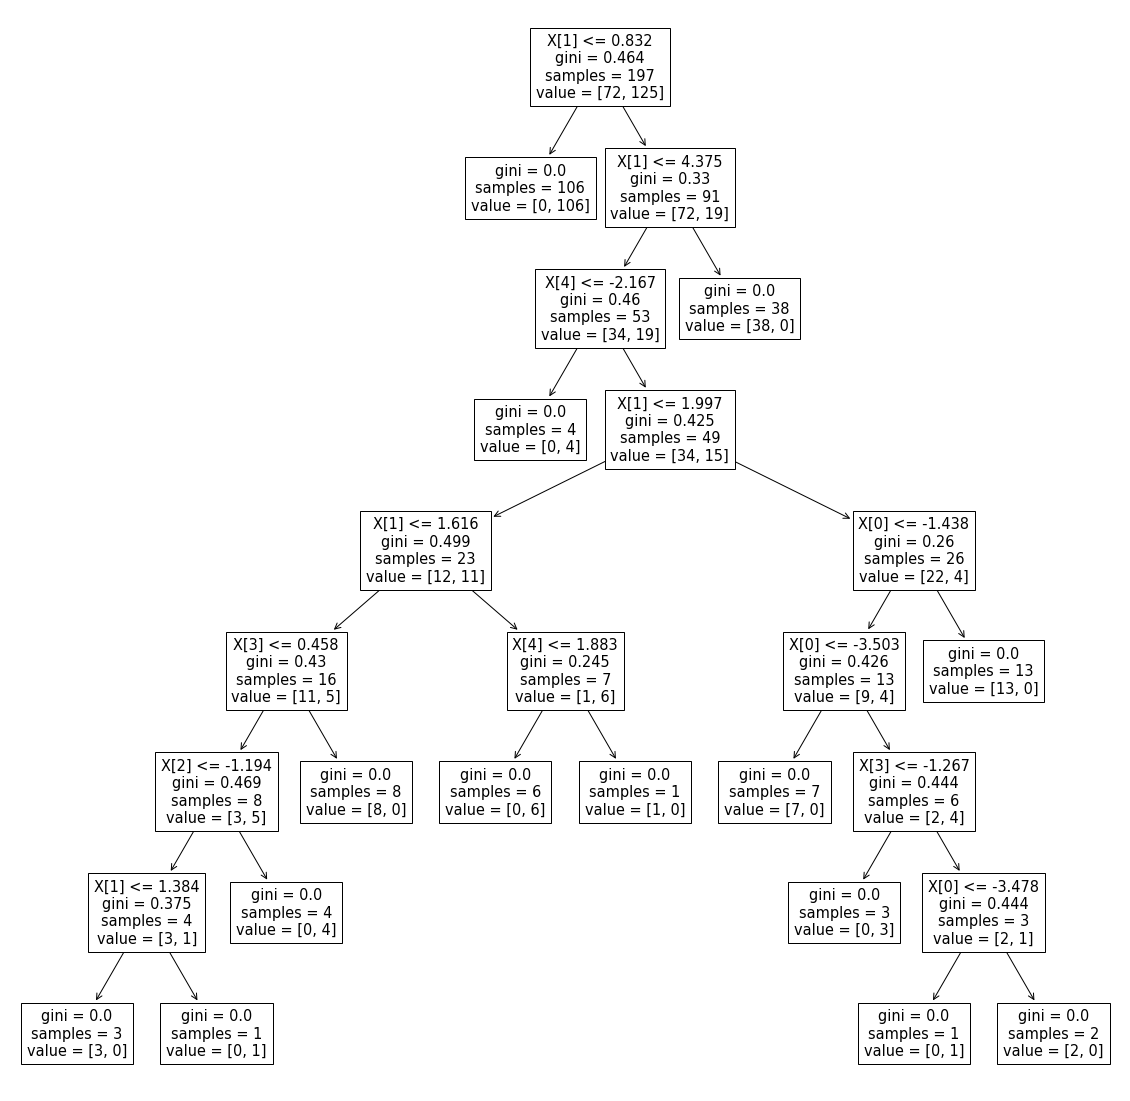

selected sample:
[ 8.60231553e+00  2.40520527e+00  2.30684342e+00 -1.45726746e+00
 -1.72703874e-03], prediction : [0]


In [297]:
from sklearn import tree
# split data set
x_train, x_test = x[:x.shape[0]//2], x[x.shape[0]//2:]
y_train, y_test = y_binary[:y_binary.shape[0]//2], y_binary[y_binary.shape[0]//2:]
x_train, x_test = pca_transform(x_train, x_test, k=5)

# train a new model
DTclf = DecisionTreeClassifier(random_state=0)
DTclf.fit(x_train, y_train)
plt.figure(figsize=(20,20))
tree.plot_tree(DTclf)
plt.show()

sample = x_test[0]
print(f"selected sample:\n{sample}, prediction : {DTclf.predict(sample[None])}")

## Random Forest
### Describe the difference between boosting and bagging.  
Boosting: 雖然也是隨機選擇training data，但是會因為上一個classifier做錯而影響到每個sample的權重（做錯的，權重會上升），而之後的classifier會越來越專注於上一個classifier做錯的部分，也就是說每個classifier之間只會互相影響的。  
  
Bagging: 同時隨機的sample data，且權重均相等，也就是說不同classifier之間是獨立的，僅有隨機結果的不同，其目的是為了降低整體的參數量。  
而 random forest 是屬於一種 bagging 的方法。

## KNN
### Show the prediction and reasoning of one arbitrary sample in the testing set.
根據下列的code，我們先訓練一個KNN classifier並預測 x_test[0] (testing set的第一筆data) 的label為0，code的第二部分透過暴力搜尋，找到最接近的三個neighbor的label分別為 0, 0, 0，因此KNN的預測結果應為0，和我們的model預測結果相同。

In [298]:
# split data set
x_train, x_test = x[:x.shape[0]//2], x[x.shape[0]//2:]
y_train, y_test = y_binary[:y_binary.shape[0]//2], y_binary[y_binary.shape[0]//2:]
x_train, x_test = pca_transform(x_train, x_test, k=2)

# train a new model and get its output (label = 0)
k = 3
KNNclf = KNeighborsClassifier(n_neighbors=k)
KNNclf.fit(x_train, y_train)
print(f"Model prediction:\tclass {KNNclf.predict(x_test[0, None])[0]}", )

# reasoning, using exhausted search
dists = list()
sample = x_test[0]
for idx, x_training_sample in enumerate(x_train):
    dists.append((np.linalg.norm(x_training_sample - sample), y_train[idx])) # using L2 norm as distance
dists = sorted(dists)
for idx, neighbors in enumerate(dists[:k], start=1):
    print(f"Label of neighbor {idx} :\tclass {neighbors[1]}") # print label of k nearist neighbors

Model prediction:	class 0
Label of neighbor 1 :	class 0
Label of neighbor 2 :	class 0
Label of neighbor 3 :	class 0


## Bonus: pick 2 features, draw and describe the KNN decision boundaries.
首先透過PCA將維度降為 2 dimension，在透過建立網格點（mesh）來模擬出KNN的decision boundary，兩種顏色分別代表兩種class（binary classification）  

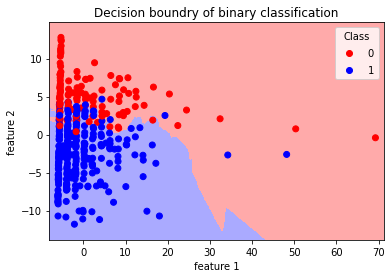

In [299]:
from matplotlib.colors import ListedColormap
# PCA
X, _ = pca_transform(x, x, k=2)
Y = y_binary

# train a new model and get its output (label = 0)
k = 3
KNNclf = KNeighborsClassifier()
KNNclf.fit(X, Y)

# plot decision boundry
h = 0.1 # block size of mesh
cmap_light = ListedColormap(['#FFAAAA','#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

x_min, x_max = X[..., 0].min() - 2, X[..., 0].max() + 2
y_min, y_max = X[..., 1].min() - 2, X[..., 1].max() + 2
mesh_x, mesh_y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
in_ = np.column_stack((mesh_x.reshape(-1), mesh_y.reshape(-1)))
Z = KNNclf.predict(in_)

# plot
Z = Z.reshape(mesh_x.shape)
fig, ax = plt.subplots()
ax.pcolormesh(mesh_x, mesh_y, Z, shading='auto', cmap=cmap_light)
scatter = ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap_bold)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title("Decision boundry of binary classification")
legend = ax.legend(*scatter.legend_elements(), title="Class")
plt.show()

## PCA
### In 5-Level classification, reduce the data dimension to 2 using PCA and draw a scatter plot. You have to colorize the data points based on their labels.

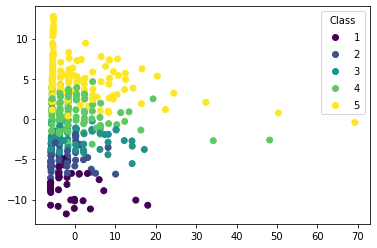

In [300]:
from matplotlib.colors import ListedColormap
# PCA
X, _ = pca_transform(x, x, k=2)
Y = y_5class
fig, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=Y)
legend = ax.legend(*scatter.legend_elements(), title="Class")
plt.show()